In [25]:
import numpy as np
import pandas as pd
import geopandas as gpd
import libpysal as ps
import matplotlib.pyplot as plt

from tqdm import tqdm
from mygwr.gwr import GWR
from mygwr.sel_bw import Sel_BW
from libpysal.weights import lat2W
from multiprocessing.pool import ThreadPool

In [2]:
# Spatial eigenvector extraction function for making smooth simulated data

def extract_sf(w, style='B'):
    w.transform = style
    C, ids = ps.weights.full(w)
    n = C.shape[0]
    M = np.identity(n) - (float(1)/float(n))
    MCM = np.dot(np.dot(M,C),M)
    vals, vecs = np.linalg.eigh(MCM)
    vals, vecs = np.array(vals), np.array(vecs.T)
    #Sort vals and vecs because they aren't in decending order in python
    pairs = zip(vals, vecs)
    svals = sorted(vals, reverse=True)
    stups = [None] * len(svals)
    for e_val, vector in pairs:
        stups[svals.index(e_val)] = (e_val, vector)
        svals[svals.index(e_val)] = None
    vecs = np.array([x[1] for x in stups])
    vals = np.array([x[0] for x in stups])
    return vals, vecs

# Make data

In [3]:
size = 25
n = size**2
noiselvl = 0.25
Wlat = lat2W(nrows=25, ncols=25, rook=False)

evals, evecs = extract_sf(Wlat)
data = {'global' : 0.5*np.ones((size, size)),
        'regional' : evecs[0, :].reshape(size, size), 
        'local' : evecs[9, :].reshape(size, size)}
X = data['regional'].reshape(-1, 1)*1e3

betas = evecs[1, :].reshape(-1, 1)
y = X*betas + np.random.normal(loc=0, scale=noiselvl, size=(size**2, 1))

grids = np.meshgrid(range(size), range(size))
coords = np.hstack((grids[0].reshape(-1, 1), grids[1].reshape(-1, 1)))

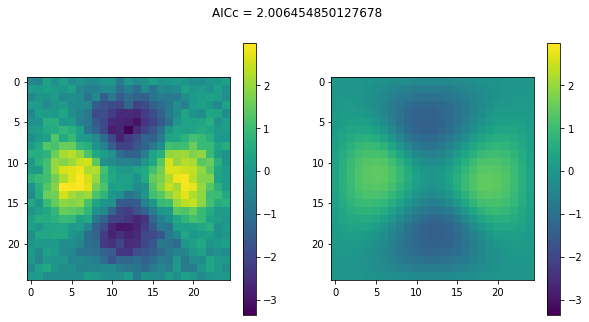

In [4]:
model = GWR(coords, y, X, 200).fit()

vmax = max(y.max(), model.predy.max())
vmin = min(y.min(), model.predy.min())

_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
c1 = ax1.imshow(y.reshape(size, size), vmin=vmin, vmax=vmax)
c2 = ax2.imshow(model.predy.reshape(size, size), vmin=vmin, vmax=vmax)
plt.suptitle(f'AICc = {model.loss()}')
plt.colorbar(c1, ax=ax1)
plt.colorbar(c2, ax=ax2)
plt.show()

# Find true optimal bandwidth according to a grid search

In [6]:
pool = ThreadPool(10)
grid_selector = Sel_BW(coords, y, X, optimizer='grid')
grid_results = grid_selector.select(bw_min=2, bw_max=500, full=True, pool=pool)

In [ ]:
grid_results['min']  # true min bw

500

# Play with PSO parameters
## Inertia parameter

In [32]:
pso_selector = Sel_BW(coords, y, X, optimizer='pso')

avging = 30
inertia_results = dict.fromkeys(np.linspace(0.05, 1, num=10), 0)
for inertia_wgt in tqdm(inertia_results.keys()):
    for _ in range(avging):
        inertia_results[inertia_wgt] += pso_selector.select(n_particles=10, bw_min=2, bw_max=200, max_iter=25, tol=1e-6, inertia_wgt=inertia_wgt)/avging

100%|██████████| 10/10 [19:51<00:00, 119.13s/it]


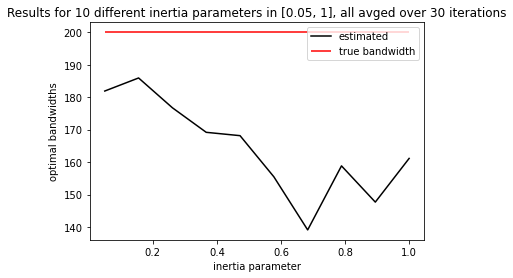

In [33]:
plt.plot(inertia_results.keys(), inertia_results.values(), 'k', label='estimated')
plt.hlines(200, xmin=0.05, xmax=1, colors='r', label='true bandwidth')
plt.xlabel('inertia parameter')
plt.ylabel('optimal bandwidths')
plt.legend()
plt.title(f'Results for 1a0 different inertia parameters in [0.05, 1], all avged over {avging} iterations')
plt.show()

## Cognitive coefficient

In [21]:
pso_selector = Sel_BW(coords, y, X, optimizer='pso')

avging = 10
cog_results = dict.fromkeys(np.linspace(1, 3, num=30), 0)
for cog_coef in cog_results.keys():
    for _ in range(avging):
        cog_results[cog_coef] += pso_selector.select(n_particles=10, bw_min=2, bw_max=200, max_iter=25, tol=1e-6, cog_coef=cog_coef)/avging

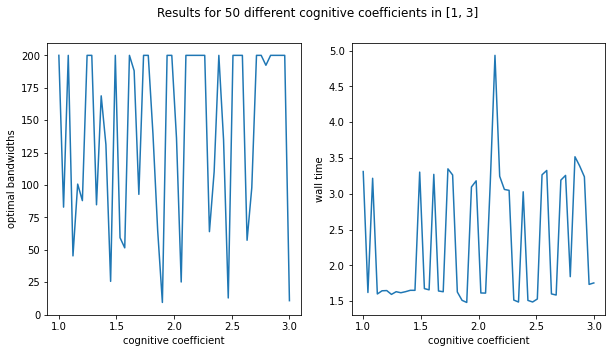

In [22]:
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.plot(cog_results.keys(), [v['min'] for v in cog_results.values()])
ax1.set_xlabel('cognitive coefficient')
ax1.set_ylabel('optimal bandwidths')

ax2.plot(cog_results.keys(), [v['wall'] for v in cog_results.values()])
ax2.set_xlabel('cognitive coefficient')
ax2.set_ylabel('wall time')

plt.suptitle('Results for 50 different cognitive coefficients in [1, 3]')
plt.show()

## Social coefficient

In [23]:
pso_selector = Sel_BW(coords, y, X, optimizer='pso')

soc_results = dict.fromkeys(np.linspace(1, 3, num=50))
for soc_coef in soc_results.keys():
    soc_results[soc_coef] = pso_selector.select(n_particles=10, bw_min=2, bw_max=200, max_iter=25, tol=1e-6, soc_coef=soc_coef, full=True)

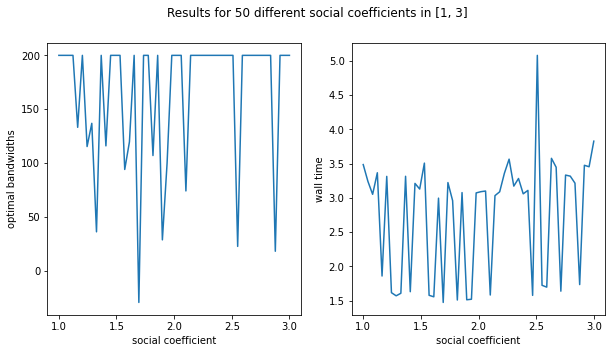

In [24]:
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.plot(soc_results.keys(), [v['min'] for v in soc_results.values()])
ax1.set_xlabel('social coefficient')
ax1.set_ylabel('optimal bandwidths')

ax2.plot(soc_results.keys(), [v['wall'] for v in soc_results.values()])
ax2.set_xlabel('social coefficient')
ax2.set_ylabel('wall time')

plt.suptitle('Results for 50 different social coefficients in [1, 3]')
plt.show()